# **Project Work in Machine Learning: OSMI Mental Health in Tech Survey**

### **Stefano Poggi Cavalletti**

### **Master's degree in Artificial Intelligence - Unibo**


## Description

The dataset used is OSMI Mental Health in Tech, available on Kaggle, which measures the attitude and frequency towards mental health disorders in the context of tech workplace. This survey was filled by respondents who suffer from mental health disorders in tech companies to see if any factors can affect the employee to get treatment or not.

The task consists in analyzing the data and predicting individual’s mental health treatment based on different features (e.g. age, gender, country and several answers about workers' mental health and work) through the deployment of machine learning models.

In [27]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

random_state = 42

## Dataset loading and exploration

We load the dataset (in the .csv format) with the Pandas function `read_csv`, output its number of rows and columns and show the first rows

In [28]:
df = pd.read_csv('survey.csv')
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns')

There are 1259 rows and 27 columns


In [29]:
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [30]:
# Descriptive statistics
df.describe()

,Age
count,1.259000e+03
mean,7.942815e+07
std,2.818299e+09
min,-1.726000e+03
25%,2.700000e+01
50%,3.100000e+01
75%,3.600000e+01
max,1.000000e+11


The followings are the columns available in the dataset:

* **Timestamp**
* **Age**
* **Gender**
* **Country state**: If you live in the United States, which state or territory do you live in?
* **self_employed**: Are you self-employed?
* **family_history**: Do you have a family history of mental illness?
* **treatment**: Have you sought treatment for a mental health condition?
* **work_interfere**: If you have a mental health condition, do you feel that it interferes with your work?
* **no_employees**: How many employees does your company or organization have?
* **remote_work**: Do you work remotely (outside of an office) at least 50% of the time?
* **tech_company**: Is your employer primarily a tech company/organization?
* **benefits**: Does your employer provide mental health benefits?
* **care_options**: Do you know the options for mental health care your employer provides?
* **wellness_program**: Has your employer ever discussed mental health as part of an employee wellness program?
* **seek_help**: Does your employer provide resources to learn more about mental health issues and how to seek help?
* **anonymity**: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?
* **leave**: How easy is it for you to take medical leave for a mental health condition?
* **mental_health_consequence**: Do you think that discussing a mental health issue with your employer would have negative consequences?
* **phys_health_consequence**: Do you think that discussing a physical health issue with your employer would have negative consequences?
* **coworkers**: Would you be willing to discuss a mental health issue with your coworkers?
* **phys_health_interview**: Would you bring up a physical health issue with a potential employer in an interview?
* **mental_vs_physical**: Do you feel that your employer takes mental health as seriously as physical health?
* **obs_consequence**: Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?
* **comments**: Any additional notes or comments


By taking a first look at data, it appears that the majority of the features are categorical and also many null values are present, which should be removed

## Data preprocessing

Find the columns which contain NaN values and count them


In [31]:
df.isna().sum()

Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64

Remove columns with NaN values or meaningless information and for `self_employed` and `work_interfere` attributes, null values are replaced with the most common ones

In [32]:
df = df.drop(['comments'], axis= 1)
df = df.drop(['state'], axis= 1)
df = df.drop(['Timestamp'], axis= 1)

In [33]:
df['self_employed'] = df['self_employed'].fillna('No')
df['work_interfere'] = df['work_interfere'].fillna('Sometimes')

Since there is a variety of values for the genders, the function `gender_encoding` groups them into Male, Female or Others and it is later applied to `df['Gender']`

In [34]:
def gender_encoding(x):
    # male
    if x.lower()[0] == 'm' or x.lower() in {'cis man', 'cis male','cis male'}:
        return 'Male'
    # female
    elif x.lower()[0] == 'f' or x.lower() in {'cis female', 'woman','cis-female/femme'}:
        return 'Female'
    # other
    else:
        return 'Other'

In [35]:
df['Gender'] = df['Gender'].apply(gender_encoding)

Some age values appear to be negative or too big, so they are removed

In [36]:
df = df[(df['Age']>0) & (df['Age']<100)]

## Exploratory Data Analysis

Performing data analysis to see how the features are correlated and to infer some knowledge.

First of all, `Gender` is considered to see whether it is an important factor for treatment. From the plot it appears that men are much more likely to seek out treatment compared to other genders, highly due to the fact that they represent the most common gender in the dataset.

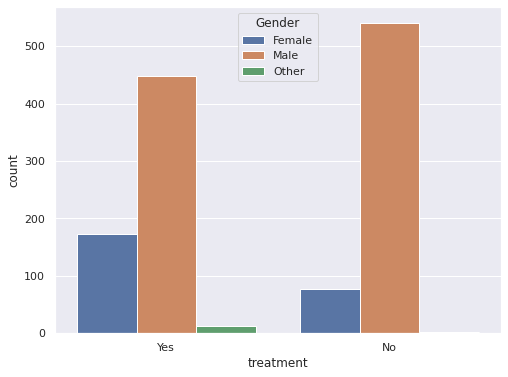

In [37]:
sns.set(rc = {'figure.figsize':(8,6)})
sns.countplot(data=df,x='treatment', hue='Gender')

Plotting the number of employees across the different countries: as it can be seen, the number of participants from the USA is much higher compared to any other country.

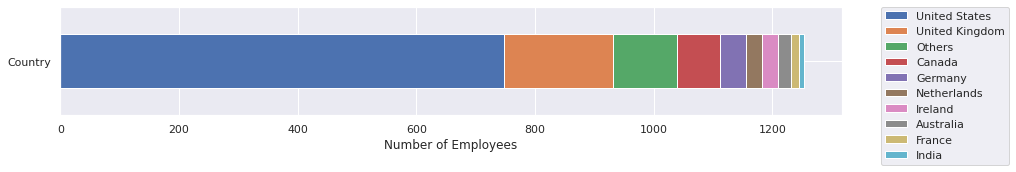

In [38]:
df.loc[df.Country.value_counts()[df.Country].values < 10, 'Country'] = "Others"
labels = df.Country.unique().tolist()
plt.rcParams["figure.figsize"] = (14, 2)
ax = pd.DataFrame(df['Country'].value_counts()).T.plot(kind='barh', stacked=True)
ax.set_xlabel("Number of Employees")
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.0)
plt.show() 

Exploring the relationship between age and treatment status


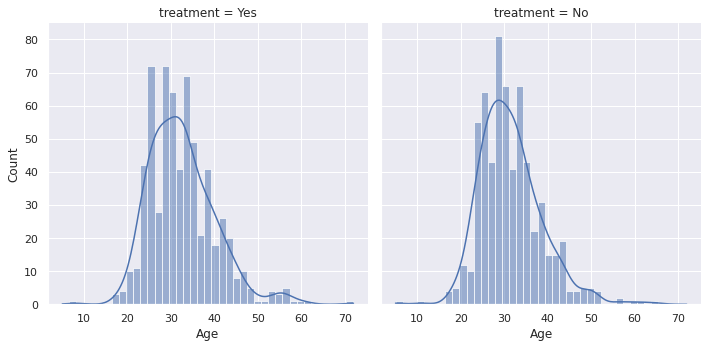

In [39]:
sns.displot(data=df, x='Age',col='treatment',kde=True)

Now the other features are plotted (with matplotlib and seaborn libraries) and analyzed

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

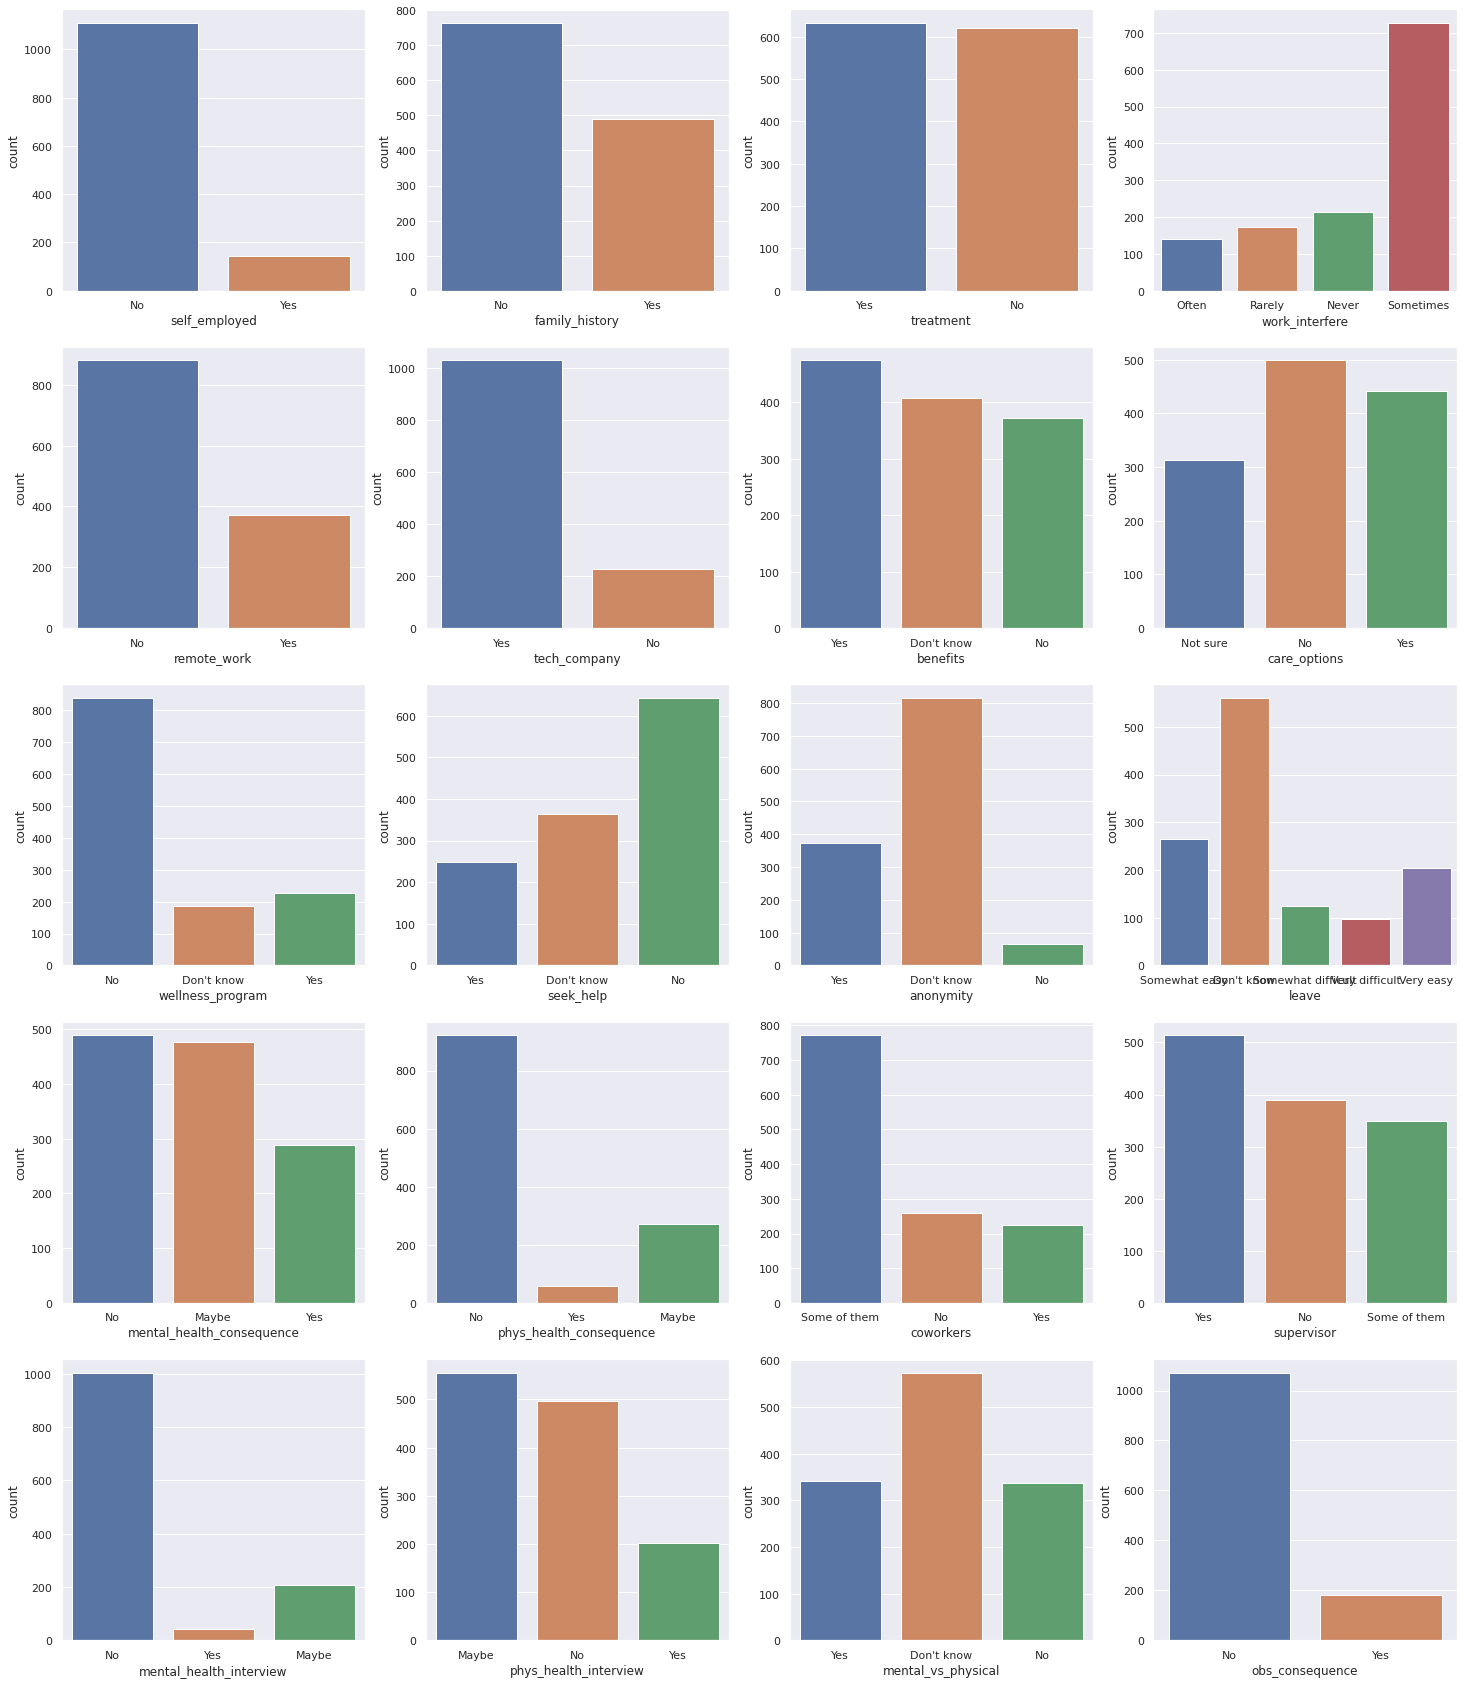

In [40]:
# list of columns
columns = ['self_employed', 'family_history', 'treatment', 'work_interfere', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']

# plot the count plot for each categorical variable 
fig, ax = plt.subplots(nrows = 5, ncols = 4, figsize=(25, 30))

# use for loop to plot the count plot for each column
for col, subplot in zip(columns, ax.flatten()):
    
    # use countplot() to plot the graph
    sns.countplot(df[col], ax = subplot)

# display the plot
plt.show()

By analyzing the plots for each feature we can infer some relevant information:

* The number of people who are self employed is only around one tenth compared to those who are not

* The percentages of respondents who want and do not want to get treatment are balanced and nearly equal to 50

* Fewer respondents claim to have a family history of mental illness but it is more likely that they want to get treatment compared to those without a family history. Hence, this is an important factor to take into consideration

* Around half of the people say that sometimes work interfers with their mental health, which is much higher compared to the others

* The majority of respondents don't work remotely, which means the biggest factor of mental health issues is related to workplace

* Most of the people seeking for help are working in the tech industry

* Around 40% of the respondents said that their employer provided them mental health benefits, while a significant number didn't know whether they were provided this benefit

* Only about 20% of the repondents say yes about becoming a part of the employee wellness program

* The majority of people were not aware whether anonymity was provided to them

* Most people answered that they did not know about it, but a small percentage of people said that it was very difficult for them to get leave for mental health

* Nearly the same amount of people answered to 'Maybe' as well as 'No' for the negative impact of discussing mental health consequences with the employer, while only fewer responded 'No'. There is a difference between the reponses for the same question regarding physical health consequences: the clear majority of people answered 'No'

* Most employees said that they might be comfortable discussing about their mental problems with their supervisors, while only some of their mental issues with their coworkers

* Nearly 80% of the respondents believe that it is a good option to discuss mental health with a future employer in an interview

* There is a balanced opinion (Yes/No) about whether participants think that employers take mental health as seriously as physical health

* Most respondents did not observe any negative consequence for coworkers with mental health conditions in their workplace





Plotting a correlation heatmap to see the correlation between variables

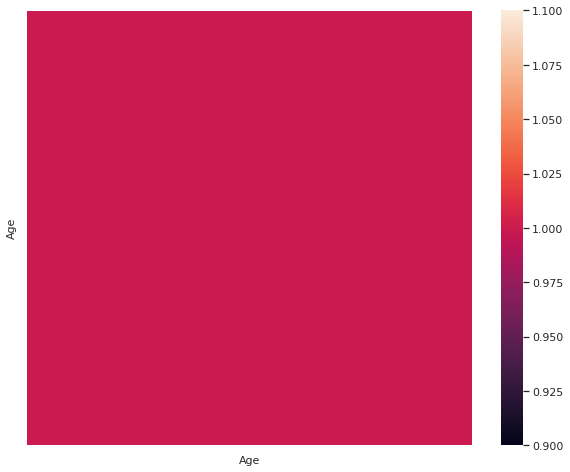

In [41]:
correlation_matrix = df.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, linewidths=.5);
plt.show()

## Data encoding

Features are encoded using `LabelEncoder` from `sklearn.preprocessing`, which encodes target labels with value between 0 and n_classes-1.

In [42]:
label_encoder = LabelEncoder()
for feature in df:
    label_encoder.fit(df[feature])
    df[feature] = label_encoder.transform(df[feature])

**Scaling**: the Age attribute is scaled to normalize values in the range [0,1] with the `MinMax scaler`.

In [43]:
scaler = MinMaxScaler(feature_range=(0,1))
df['Age'] = scaler.fit_transform(df[['Age']])

Splitting dataset into train and validation set

In [44]:
X = df.drop('treatment', axis = 1)
y = df['treatment']

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.3,
                                                    random_state=random_state)

## Definition and employment of different models

The chosen models are Support Vector Machine, Logistic Regressor, K-Nearest Neighbor, Random Forest and XGB Classifier, which are defined along with their hyperparameters.

In [45]:
# models labels
model_lbls = ['svc','knn','rfc','lgr','xgb']

# models parameters
tuned_param_svc = [{'kernel': ['rbf'], 
                    'cache_size': [8000], 
                    'gamma': ['scale', 1e-3, 1e-4],
                    'C': [10, 100, 1000],
                    'probability' : [True]
                    },
                   {'kernel': ['linear'],
                    'cache_size': [8000],
                    'C': [10, 100, 1000]
                    }]

tuned_param_knn =[{'n_neighbors': list(range(1,11)),
                   'metric': ['euclidean', 'manhattan', 'chebyshev']}]

tuned_param_rfc =[{'max_depth': list(range(5,51,5))}]

tuned_param_lgr = [{'solver' : ['liblinear', 'lbfgs'],
                    'max_iter':range(100, 1000, 50),
                    'C': [1,2,3]}]

tuned_param_xgb = [{'n_estimators':range(50, 600, 50),
                  'learning_rate': [0.01, 0.05, 0.1],
                  'max_depth':range(3, 10, 1)}]

# models
models = {
    'svc':{'name': 'Support Vector',
           'estimator': SVC(), 
           'param': tuned_param_svc
          },
    'knn':{'name': 'K Nearest Neighbor',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn      
          },
    'rfc':{'name': 'Random Forest',
           'estimator': RandomForestClassifier(),
           'param': tuned_param_rfc
          },
    'lgr':{'name': 'Logistic Regression',
           'estimator': LogisticRegression(),
           'param': tuned_param_lgr
          },
    'xgb':{'name': 'XGB Classifier',
           'estimator': XGBClassifier(),
           'param': tuned_param_xgb
          }
}

scores = ['accuracy', 'f1_macro']

The function `output_acc_f1(model)` takes the model in input and computes the `accuracy` and `f1  score` values with the `accuracy_score()` and `f1_score()` functions, respectively. These values are then printed as output.

In [46]:
def output_acc_f1(model):
    print("Best parameters set found on train set:\n")
    print(model.best_params_)
    print("\nGrid scores on train set:\n")

    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']

    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params_tuple))

    print("\nScores for the best parameter set:\n")
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.\n")

    # compute accuracy and f1 score for the given model
    y_true, y_pred = y_test, model.predict(X_test)
    acc, f1 = accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro')

    print(f'Accuracy: {acc:.2f}%')
    print(f'F1-macro: {f1:.2f}%')

    return acc, f1

The function `plot_roc()` takes the model in input and plots the ROC curve using the `matplotlib` library. In order to do so, the `fpr` (false positive rate), `tpr` (true positive rate) and `thresholds` are computed by the `roc_curve()` function, while the AUC (Area Under Curve) Score is computed with the function `roc_auc_score()`.

In [47]:
# define a function to plot the ROC curve and compute the ROC-AUC score
def plot_roc(model):

    # the roc_curve() returns the values for false positive rate, true positive rate and threshold
    y_true, y_pred_prob = y_test, model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = roc_auc_score(y_true, y_pred_prob)

    plt.figure(figsize=(9,7))

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # plot the ROC curve
    plt.plot(fpr, tpr)

    # add text to show AUC Score
    plt.text(x = 0.02, y = 0.9, s = (f'AUC Score: {roc_auc:.2f}'))

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('ROC Curve', fontsize = 15)
    plt.xlabel('False positive rate', fontsize = 15)
    plt.ylabel('True positive rate', fontsize = 15)

    plt.show()

The `train_and_evaluate()` function takes in input `X_train` and `y_train` and applies cross validation on the defined models, tuning them for both accuracy and f1-macro score, while the best models are saved.

In [48]:
def train_and_evaluate(X_train, y_train):  
  results_short = {}
  results = {}
  for score in scores:
      print('='*40)
      print("# Tuning hyper-parameters for %s \n" % score)
      for m in model_lbls:
          print('-'*40)
          print(f"Trying model {models[m]['name']}\n")

          # find optimal parameters for the model using GridSearchCV (cross validation)
          clf = GridSearchCV(models[m]['estimator'], 
                             models[m]['param'], 
                             cv=3,
                             scoring=score, # accuracy/f1_macro
                             return_train_score = False,
                             n_jobs = -1, # this allows using multi-cores,
                             verbose=0
                             )
          clf.fit(X_train, y_train.values.ravel())
          # get accuracy and f1
          acc, f1 = output_acc_f1(clf)
          # plot roc curve 
          plot_roc(clf)
          results_short[m] = (acc, f1)
          # save models 
          filename = models[m]['name'] + "_" + score + "_" + str(datetime.now().time())[:8] + '.sav'
          results[filename[:-13]] = {"accuracy" : acc,
                                     "f1-macro" : f1,
                                     "params" : clf.best_params_
          }

      # summary of all computed estimators, using their best one param
      print('='*40)
      print(f"Summary of results of models tuned for {score}\n")
      print("Estimator\n")
      for m in results_short.keys():
          print(f"{models[m]['name']}\t - accuracy: {results_short[m][0]:4.2}")
          print(f"{models[m]['name']}\t - f1-macro: {results_short[m][1]:4.2}\n")
  print('='*40)
  #  return a dictionary of the performances of top classifiers
  return results

For each model, *accuracy* and *f1-macro* are printed along with the best parameters

In [49]:
def print_evaluation_scores(results):
  for model, _ in results.items():
    params = ""
    for param_name, v in results[model]["params"].items():
      params += param_name + ": " + str(v) + ", "
    params = params[:-2]
    
    print("-"*40)
    print(f"{model}\t - accuracy: {results[model]['accuracy']:4.2} with params=[{params}]")
    print(f"{model}\t - f1-macro: {results[model]['f1-macro']:4.2} with params=[{params}]\n")

# Tuning hyper-parameters for accuracy 

----------------------------------------
Trying model Support Vector

Best parameters set found on train set:

{'C': 10, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}

Grid scores on train set:

0.713 (+/-0.010) for {'C': 10, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
0.684 (+/-0.015) for {'C': 10, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}
0.639 (+/-0.027) for {'C': 10, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf', 'probability': True}
0.666 (+/-0.023) for {'C': 100, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
0.702 (+/-0.038) for {'C': 100, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}
0.684 (+/-0.028) for {'C': 100, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf', 'probability': True}
0.625 (+/-0.025) for {'C': 1000, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf', 'probab

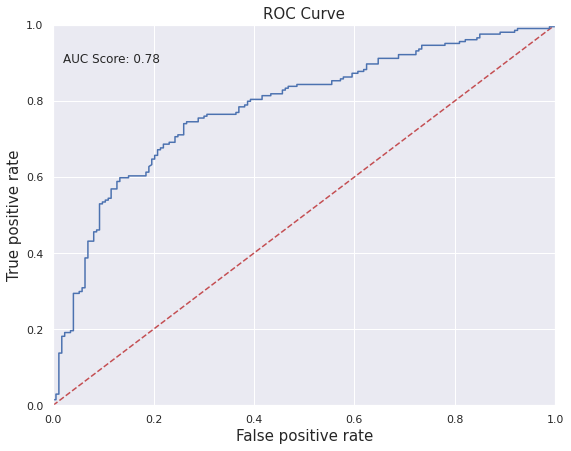

----------------------------------------
Trying model K Nearest Neighbor

Best parameters set found on train set:

{'metric': 'manhattan', 'n_neighbors': 9}

Grid scores on train set:

0.627 (+/-0.062) for {'metric': 'euclidean', 'n_neighbors': 1}
0.631 (+/-0.005) for {'metric': 'euclidean', 'n_neighbors': 2}
0.651 (+/-0.040) for {'metric': 'euclidean', 'n_neighbors': 3}
0.639 (+/-0.035) for {'metric': 'euclidean', 'n_neighbors': 4}
0.645 (+/-0.019) for {'metric': 'euclidean', 'n_neighbors': 5}
0.637 (+/-0.030) for {'metric': 'euclidean', 'n_neighbors': 6}
0.648 (+/-0.047) for {'metric': 'euclidean', 'n_neighbors': 7}
0.652 (+/-0.032) for {'metric': 'euclidean', 'n_neighbors': 8}
0.645 (+/-0.033) for {'metric': 'euclidean', 'n_neighbors': 9}
0.648 (+/-0.021) for {'metric': 'euclidean', 'n_neighbors': 10}
0.634 (+/-0.037) for {'metric': 'manhattan', 'n_neighbors': 1}
0.624 (+/-0.016) for {'metric': 'manhattan', 'n_neighbors': 2}
0.659 (+/-0.037) for {'metric': 'manhattan', 'n_neighbors'

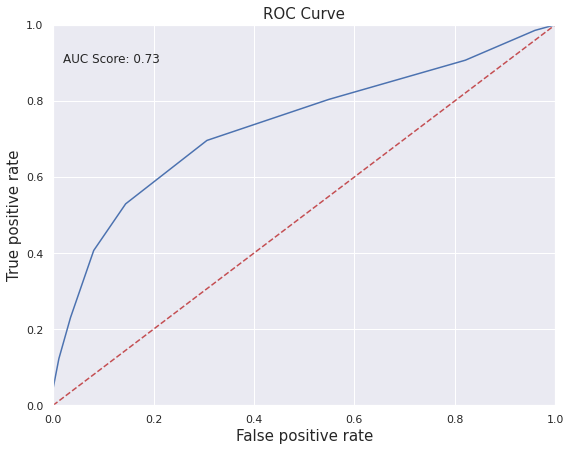

----------------------------------------
Trying model Random Forest

Best parameters set found on train set:

{'max_depth': 5}

Grid scores on train set:

0.733 (+/-0.015) for {'max_depth': 5}
0.726 (+/-0.049) for {'max_depth': 10}
0.716 (+/-0.032) for {'max_depth': 15}
0.725 (+/-0.047) for {'max_depth': 20}
0.729 (+/-0.029) for {'max_depth': 25}
0.727 (+/-0.026) for {'max_depth': 30}
0.721 (+/-0.037) for {'max_depth': 35}
0.712 (+/-0.033) for {'max_depth': 40}
0.730 (+/-0.043) for {'max_depth': 45}
0.709 (+/-0.029) for {'max_depth': 50}

Scores for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

Accuracy: 0.78%
F1-macro: 0.78%


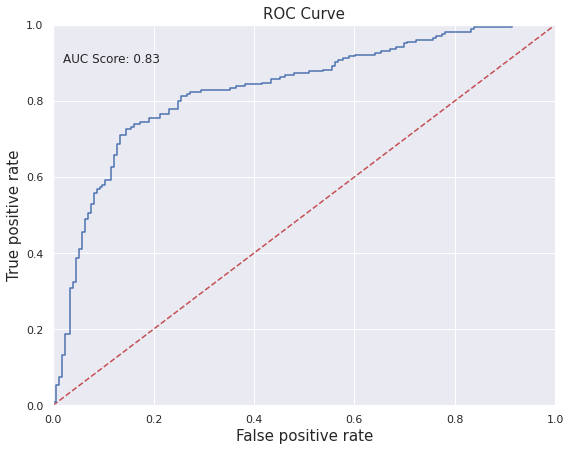

----------------------------------------
Trying model Logistic Regression



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Best parameters set found on train set:

{'C': 3, 'max_iter': 100, 'solver': 'lbfgs'}

Grid scores on train set:

0.690 (+/-0.045) for {'C': 1, 'max_iter': 100, 'solver': 'liblinear'}
0.693 (+/-0.056) for {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}
0.690 (+/-0.045) for {'C': 1, 'max_iter': 150, 'solver': 'liblinear'}
0.693 (+/-0.056) for {'C': 1, 'max_iter': 150, 'solver': 'lbfgs'}
0.690 (+/-0.045) for {'C': 1, 'max_iter': 200, 'solver': 'liblinear'}
0.693 (+/-0.056) for {'C': 1, 'max_iter': 200, 'solver': 'lbfgs'}
0.690 (+/-0.045) for {'C': 1, 'max_iter': 250, 'solver': 'liblinear'}
0.693 (+/-0.056) for {'C': 1, 'max_iter': 250, 'solver': 'lbfgs'}
0.690 (+/-0.045) for {'C': 1, 'max_iter': 300, 'solver': 'liblinear'}
0.693 (+/-0.056) for {'C': 1, 'max_iter': 300, 'solver': 'lbfgs'}
0.690 (+/-0.045) for {'C': 1, 'max_iter': 350, 'solver': 'liblinear'}
0.693 (+/-0.056) for {'C': 1, 'max_iter': 350, 'solver': 'lbfgs'}
0.690 (+/-0.045) for {'C': 1, 'max_iter': 400, 'solver': 'liblinear'}


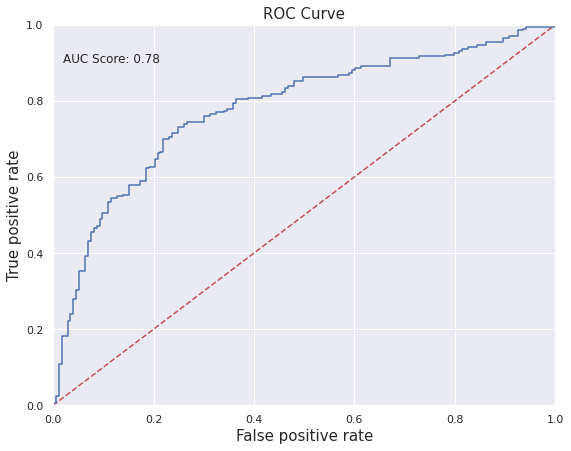

----------------------------------------
Trying model XGB Classifier

Best parameters set found on train set:

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}

Grid scores on train set:

0.730 (+/-0.025) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.726 (+/-0.020) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.731 (+/-0.022) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
0.732 (+/-0.038) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
0.740 (+/-0.030) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.735 (+/-0.033) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
0.738 (+/-0.026) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 350}
0.734 (+/-0.027) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
0.732 (+/-0.024) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 450}
0.734 (+/-0.027) for {'learning_rate': 0.01, 'max_depth': 3, 'n_

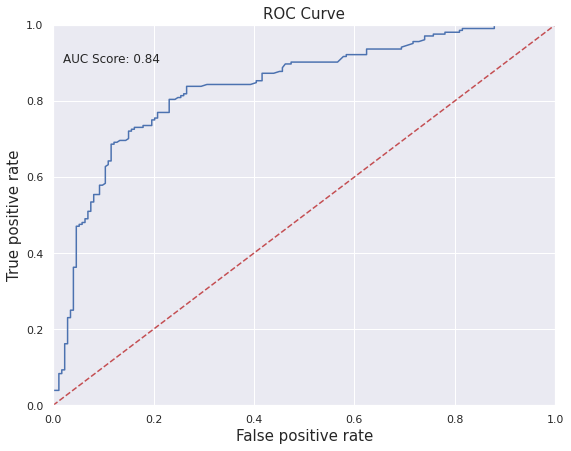

Summary of results of models tuned for accuracy

Estimator

Support Vector	 - accuracy: 0.71
Support Vector	 - f1-macro: 0.71

K Nearest Neighbor	 - accuracy: 0.68
K Nearest Neighbor	 - f1-macro: 0.68

Random Forest	 - accuracy: 0.78
Random Forest	 - f1-macro: 0.78

Logistic Regression	 - accuracy: 0.72
Logistic Regression	 - f1-macro: 0.72

XGB Classifier	 - accuracy: 0.77
XGB Classifier	 - f1-macro: 0.77

# Tuning hyper-parameters for f1_macro 

----------------------------------------
Trying model Support Vector

Best parameters set found on train set:

{'C': 10, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}

Grid scores on train set:

0.712 (+/-0.009) for {'C': 10, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
0.682 (+/-0.014) for {'C': 10, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}
0.632 (+/-0.034) for {'C': 10, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf', 'probability': True}
0.666

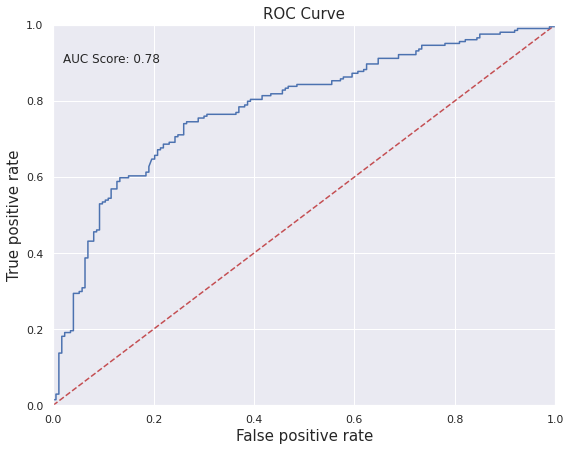

----------------------------------------
Trying model K Nearest Neighbor

Best parameters set found on train set:

{'metric': 'manhattan', 'n_neighbors': 9}

Grid scores on train set:

0.626 (+/-0.060) for {'metric': 'euclidean', 'n_neighbors': 1}
0.602 (+/-0.013) for {'metric': 'euclidean', 'n_neighbors': 2}
0.650 (+/-0.039) for {'metric': 'euclidean', 'n_neighbors': 3}
0.623 (+/-0.033) for {'metric': 'euclidean', 'n_neighbors': 4}
0.645 (+/-0.019) for {'metric': 'euclidean', 'n_neighbors': 5}
0.628 (+/-0.028) for {'metric': 'euclidean', 'n_neighbors': 6}
0.646 (+/-0.048) for {'metric': 'euclidean', 'n_neighbors': 7}
0.644 (+/-0.033) for {'metric': 'euclidean', 'n_neighbors': 8}
0.643 (+/-0.035) for {'metric': 'euclidean', 'n_neighbors': 9}
0.641 (+/-0.027) for {'metric': 'euclidean', 'n_neighbors': 10}
0.633 (+/-0.036) for {'metric': 'manhattan', 'n_neighbors': 1}
0.594 (+/-0.018) for {'metric': 'manhattan', 'n_neighbors': 2}
0.657 (+/-0.037) for {'metric': 'manhattan', 'n_neighbors'

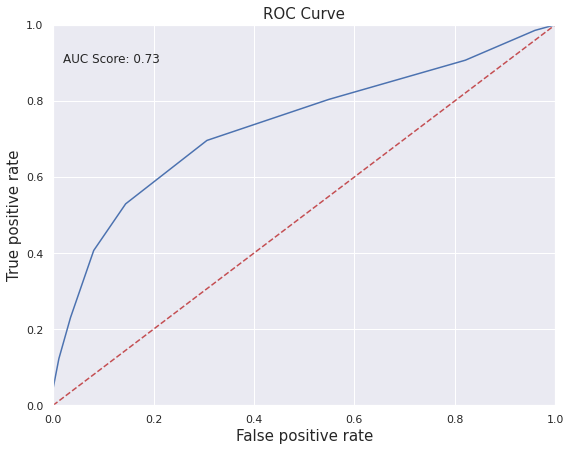

----------------------------------------
Trying model Random Forest

Best parameters set found on train set:

{'max_depth': 5}

Grid scores on train set:

0.731 (+/-0.052) for {'max_depth': 5}
0.727 (+/-0.028) for {'max_depth': 10}
0.713 (+/-0.045) for {'max_depth': 15}
0.724 (+/-0.008) for {'max_depth': 20}
0.720 (+/-0.031) for {'max_depth': 25}
0.714 (+/-0.031) for {'max_depth': 30}
0.720 (+/-0.043) for {'max_depth': 35}
0.727 (+/-0.023) for {'max_depth': 40}
0.729 (+/-0.038) for {'max_depth': 45}
0.707 (+/-0.031) for {'max_depth': 50}

Scores for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

Accuracy: 0.77%
F1-macro: 0.77%


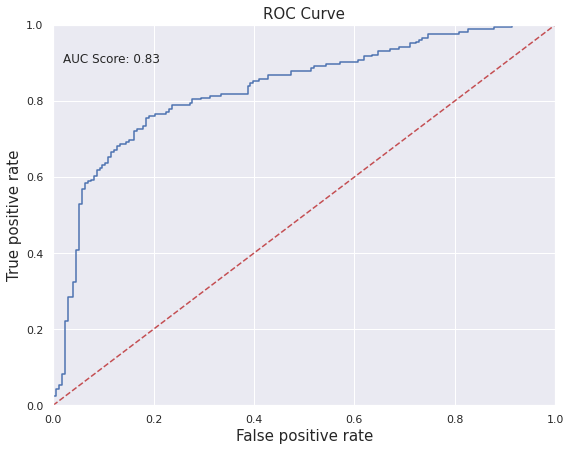

----------------------------------------
Trying model Logistic Regression



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Best parameters set found on train set:

{'C': 3, 'max_iter': 100, 'solver': 'lbfgs'}

Grid scores on train set:

0.689 (+/-0.044) for {'C': 1, 'max_iter': 100, 'solver': 'liblinear'}
0.693 (+/-0.056) for {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}
0.689 (+/-0.044) for {'C': 1, 'max_iter': 150, 'solver': 'liblinear'}
0.693 (+/-0.056) for {'C': 1, 'max_iter': 150, 'solver': 'lbfgs'}
0.689 (+/-0.044) for {'C': 1, 'max_iter': 200, 'solver': 'liblinear'}
0.693 (+/-0.056) for {'C': 1, 'max_iter': 200, 'solver': 'lbfgs'}
0.689 (+/-0.044) for {'C': 1, 'max_iter': 250, 'solver': 'liblinear'}
0.693 (+/-0.056) for {'C': 1, 'max_iter': 250, 'solver': 'lbfgs'}
0.689 (+/-0.044) for {'C': 1, 'max_iter': 300, 'solver': 'liblinear'}
0.693 (+/-0.056) for {'C': 1, 'max_iter': 300, 'solver': 'lbfgs'}
0.689 (+/-0.044) for {'C': 1, 'max_iter': 350, 'solver': 'liblinear'}
0.693 (+/-0.056) for {'C': 1, 'max_iter': 350, 'solver': 'lbfgs'}
0.689 (+/-0.044) for {'C': 1, 'max_iter': 400, 'solver': 'liblinear'}


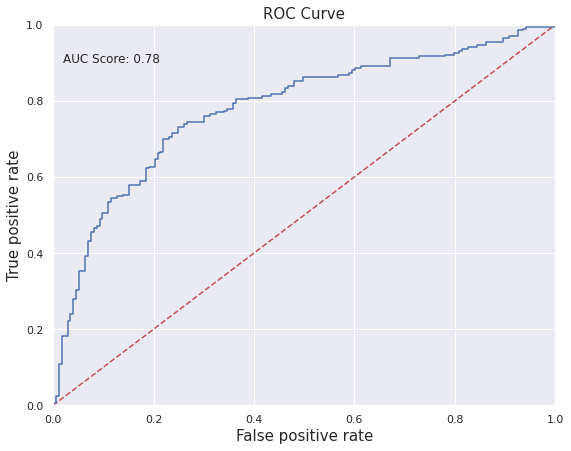

----------------------------------------
Trying model XGB Classifier

Best parameters set found on train set:

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}

Grid scores on train set:

0.730 (+/-0.025) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.726 (+/-0.020) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.731 (+/-0.021) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
0.732 (+/-0.037) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
0.740 (+/-0.030) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.735 (+/-0.033) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
0.738 (+/-0.026) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 350}
0.734 (+/-0.027) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
0.732 (+/-0.023) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 450}
0.734 (+/-0.027) for {'learning_rate': 0.01, 'max_depth': 3, 'n_

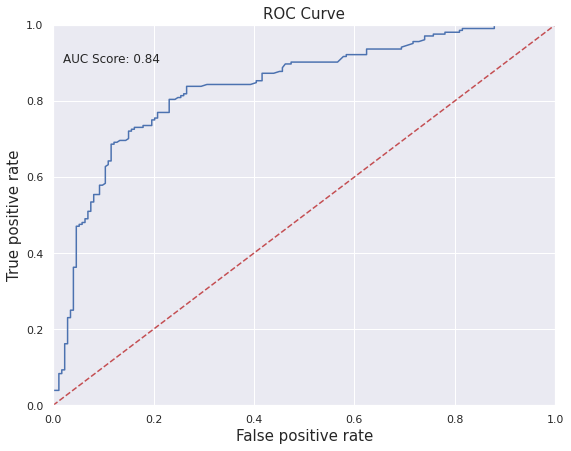

Summary of results of models tuned for f1_macro

Estimator

Support Vector	 - accuracy: 0.71
Support Vector	 - f1-macro: 0.71

K Nearest Neighbor	 - accuracy: 0.68
K Nearest Neighbor	 - f1-macro: 0.68

Random Forest	 - accuracy: 0.77
Random Forest	 - f1-macro: 0.77

Logistic Regression	 - accuracy: 0.72
Logistic Regression	 - f1-macro: 0.72

XGB Classifier	 - accuracy: 0.77
XGB Classifier	 - f1-macro: 0.77



In [50]:
results_predict = train_and_evaluate(X_train, y_train)

In [51]:
def print_evaluation_scores(results):
  for model, _ in results.items():
    params = ""
    for param_name, v in results[model]["params"].items():
      params += param_name + ": " + str(v) + ", "
    params = params[:-2]

    print("-"*40)
    print(f"{model}\t - accuracy: {results[model]['accuracy']:4.2} with params=[{params}]")
    print(f"{model}\t - f1-macro: {results[model]['f1-macro']:4.2} with params=[{params}]\n")

In [52]:
print_evaluation_scores(results_predict)

----------------------------------------
Support Vector_accuracy	 - accuracy: 0.71 with params=[C: 10, cache_size: 8000, gamma: scale, kernel: rbf, probability: True]
Support Vector_accuracy	 - f1-macro: 0.71 with params=[C: 10, cache_size: 8000, gamma: scale, kernel: rbf, probability: True]

----------------------------------------
K Nearest Neighbor_accuracy	 - accuracy: 0.68 with params=[metric: manhattan, n_neighbors: 9]
K Nearest Neighbor_accuracy	 - f1-macro: 0.68 with params=[metric: manhattan, n_neighbors: 9]

----------------------------------------
Random Forest_accuracy	 - accuracy: 0.78 with params=[max_depth: 5]
Random Forest_accuracy	 - f1-macro: 0.78 with params=[max_depth: 5]

----------------------------------------
Logistic Regression_accuracy	 - accuracy: 0.72 with params=[C: 3, max_iter: 100, solver: lbfgs]
Logistic Regression_accuracy	 - f1-macro: 0.72 with params=[C: 3, max_iter: 100, solver: lbfgs]

----------------------------------------
XGB Classifier_accuracy

## Conclusions

While performing the prediction task, five different models were deployed, all of them tuned both by accuracy and F1-macro score (which is the harmonic mean of precision and recall, where 'macro' means the metric is computed for each label, and then their mean is computed).
 
For each model, the best found parameters, accuracy, F1-macro and AUC-ROC score are reported. As it appears from the results, the best performing models were Random Forest and XGB Classifier, whereas the worst performing model was K-Nearest Neighbor.

* **Support Vector Machine**
  * Best parameters found: `{'C': 10, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}`
  * Accuracy: 0.71
  * F1-macro: 0.71
  * ROC-AUC score: 0.78

* **Logistic Regressor**
  * Best parameters found: `{'C': 3, 'max_iter': 100, 'solver': 'lbfgs'}`
  * Accuracy: 0.72
  * F1-macro: 0.72
  * ROC-AUC score: 0.78
  
* **K-Nearest Neighbor**
  * Best parameters found: `{'metric': 'manhattan', 'n_neighbors': 9}`
  * Accuracy: 0.68
  * F1-macro: 0.68
  * ROC-AUC score: 0.73

* **Random Forest**
  * Best parameters found: `{'max_depth': 25}`
  * Accuracy: 0.78
  * F1-macro: 0.78
  * ROC-AUC score: 0.83

* **XGB Classifier**
  * Best parameters found: `{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}`
  * Accuracy: 0.77
  * F1-macro: 0.77
  * ROC-AUC score: 0.84
